In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
%matplotlib inline
ox.__version__

C:\Users\think\anaconda3\envs\ox\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))
C:\Users\think\anaconda3\envs\ox\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


'1.1.2'

In [2]:
pt_nodes = gpd.read_file('./SHANGHAI/middleData/gdf_nodes.geojson')
pt_edges = gpd.read_file('./SHANGHAI/middleData/gdf_edges.geojson')
wk_nodes = gpd.read_file('./SHANGHAI/osm_shanghai_walk/gdf_nodes.geojson')
wk_edges = gpd.read_file('./SHANGHAI/osm_shanghai_walk/gdf_edges.geojson')

In [3]:
pt_nodes.head(1)

,osmid,station_names,label,line_name,x,y,geometry
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387)


In [4]:
wk_edges.head(1)

,u,v,key,length,label,wkt,geometry
0,91408837,9443491114,0,229.223,walk_edge,"LINESTRING (121.6961033 30.9196765, 121.695975...","LINESTRING (121.69610 30.91968, 121.69598 30.9..."


# 准备nodes，edges。(将公交线与walk线路串联起来）

## 最近点空间链接。离每一条公交站点最近的步行道路（坐标）

In [5]:
pt_nodes.head(1)

,osmid,station_names,label,line_name,x,y,geometry
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387)


In [6]:
wk_edges.head(1)

,u,v,key,length,label,wkt,geometry
0,91408837,9443491114,0,229.223,walk_edge,"LINESTRING (121.6961033 30.9196765, 121.695975...","LINESTRING (121.69610 30.91968, 121.69598 30.9..."


In [7]:
wk_edges['geometry']

0         LINESTRING (121.69610 30.91968, 121.69598 30.9...
1         LINESTRING (121.66202 30.90757, 121.66190 30.9...
2         LINESTRING (121.66202 30.90757, 121.66287 30.9...
3         LINESTRING (121.66202 30.90757, 121.66184 30.9...
4         LINESTRING (121.64936 30.90671, 121.64972 30.9...
                                ...                        
345749    LINESTRING (121.23433 31.49031, 121.23405 31.4...
345750    LINESTRING (121.23433 31.49031, 121.23485 31.4...
345751    LINESTRING (121.23433 31.49031, 121.23444 31.4...
345752    LINESTRING (121.23336 31.49188, 121.23335 31.4...
345753    LINESTRING (121.23481 31.49358, 121.23504 31.4...
Name: geometry, Length: 345754, dtype: geometry

In [8]:
res = pt_nodes.sjoin_nearest(wk_edges,how='left') # 该公交站点与那些步行道相邻

C:\Users\think\anaconda3\envs\ox\lib\site-packages\geopandas\array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [9]:
res.head(1)

,osmid,station_names,label_left,line_name,x,y,geometry,index_right,u,v,key,length,label_right,wkt
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387),67824,616810078,8955354756,1,164.218,walk_edge,"LINESTRING (121.3992316 31.2633834, 121.399253..."


In [10]:
len(res)

76562

## 获取分割点坐标，以及分割后的两条线段

### sample

In [11]:
from shapely.ops import split
from shapely.geometry import Point, LineString

In [12]:
line = LineString([(0, 0), (1,2),(2,2)])  # 这个是walk
point = Point(1.1,2) # 这个是公交站点,

In [13]:
d = line.project(point)  
d

2.33606797749979

In [ ]:
# https://www.osgeo.cn/shapely/manual.html#geometric-objects

In [16]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [17]:
cut(line, d) # 注意：如果点是起点或终点，则只会返回一条记录

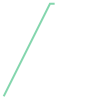

In [18]:
cut(line, d)[0]

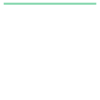

In [19]:
cut(line, d)[1]

In [20]:
cut(line, d)[0].coords[-1],cut(line, d)[1].coords[0] # 这里任意选一个，就是分割点坐标

((1.1, 2.0), (1.1, 2.0))

### 对所有数据执行操作

In [21]:
res.head(1)

,osmid,station_names,label_left,line_name,x,y,geometry,index_right,u,v,key,length,label_right,wkt
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387),67824,616810078,8955354756,1,164.218,walk_edge,"LINESTRING (121.3992316 31.2633834, 121.399253..."


In [22]:
from shapely import wkt

In [23]:
res['wkt'][0]

0    LINESTRING (121.3992316 31.2633834, 121.399253...
0    LINESTRING (121.3978929 31.2636802, 121.397925...
Name: wkt, dtype: object

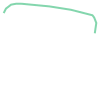

In [24]:
wkt.loads(res.iloc[0,]['wkt'])

In [25]:
def get_point_sublines(x):
    point = x[0]
    line = wkt.loads(x[1])
    distance = line.project(point)
    
    sub_lines = cut(line, distance)
    split_point = Point(sub_lines[0].coords[-1])

    return [sub_lines,split_point]

In [26]:
res['out_dt'] = res[['geometry','wkt']].apply(get_point_sublines,axis=1)

In [27]:
res.head(1)

,osmid,station_names,label_left,line_name,x,y,geometry,index_right,u,v,key,length,label_right,wkt,out_dt
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387),67824,616810078,8955354756,1,164.218,walk_edge,"LINESTRING (121.3992316 31.2633834, 121.399253...","[[LINESTRING (121.3992316 31.2633834, 121.3992..."


In [28]:
res.iloc[0,]['out_dt']

[[<shapely.geometry.linestring.LineString at 0x12515df3790>,

# 对分割点赋值osmid，并分别导出数据

In [29]:
pt_nodes['osmid'] # 这是之前公交站赋的osmid值

0            0
1            1
2            2
3            3
4            4
         ...  
53093    53093
53094    53094
53095    53095
53096    53096
53097    53097
Name: osmid, Length: 53098, dtype: int64

In [30]:
wk_nodes['osmid'].sort_values() # 这是osm地图上获取的id

16234      59608070
16235      61104104
16236      61104668
16237      61104683
16238      61104687
            ...    
70390    9816685073
70391    9816685075
70392    9816685076
70393    9816685078
70394    9816685079
Name: osmid, Length: 119999, dtype: int64

In [31]:
len(res)  # 100000-200000,选取这个区间

76562

In [32]:
pt_nodes.head(1)

,osmid,station_names,label,line_name,x,y,geometry
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387)


In [33]:
res.head(1)

,osmid,station_names,label_left,line_name,x,y,geometry,index_right,u,v,key,length,label_right,wkt,out_dt
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387),67824,616810078,8955354756,1,164.218,walk_edge,"LINESTRING (121.3992316 31.2633834, 121.399253...","[[LINESTRING (121.3992316 31.2633834, 121.3992..."


In [34]:
len(res)

76562

In [35]:
res['out_dt'].str.get(1) # 这是取获取分割点

0        POINT (121.39880109638908 31.263741262735344)
0        POINT (121.39880109638908 31.263741262735344)
1        POINT (121.39956163481689 31.262399678137683)
1        POINT (121.39956163481689 31.262399678137683)
2        POINT (121.40134539113272 31.256656925417076)
                             ...                      
53095    POINT (121.52611423831696 31.050160056373926)
53095    POINT (121.52611423831696 31.050160056373926)
53096     POINT (121.52446814270778 31.05864698657973)
53096     POINT (121.52446814270778 31.05864698657973)
53097     POINT (121.50810773961888 31.06315773013509)
Name: out_dt, Length: 76562, dtype: object

In [36]:
add_nodes = gpd.GeoDataFrame({
    'geometry':res['out_dt'].str.get(1),
    'osmid':[100000+i for i in range(len(res))],

},crs='epsg:4326')

In [37]:
add_nodes.head()

,geometry,osmid
0,POINT (121.39880 31.26374),100000
0,POINT (121.39880 31.26374),100001
1,POINT (121.39956 31.26240),100002
1,POINT (121.39956 31.26240),100003
2,POINT (121.40135 31.25666),100004


<AxesSubplot:>

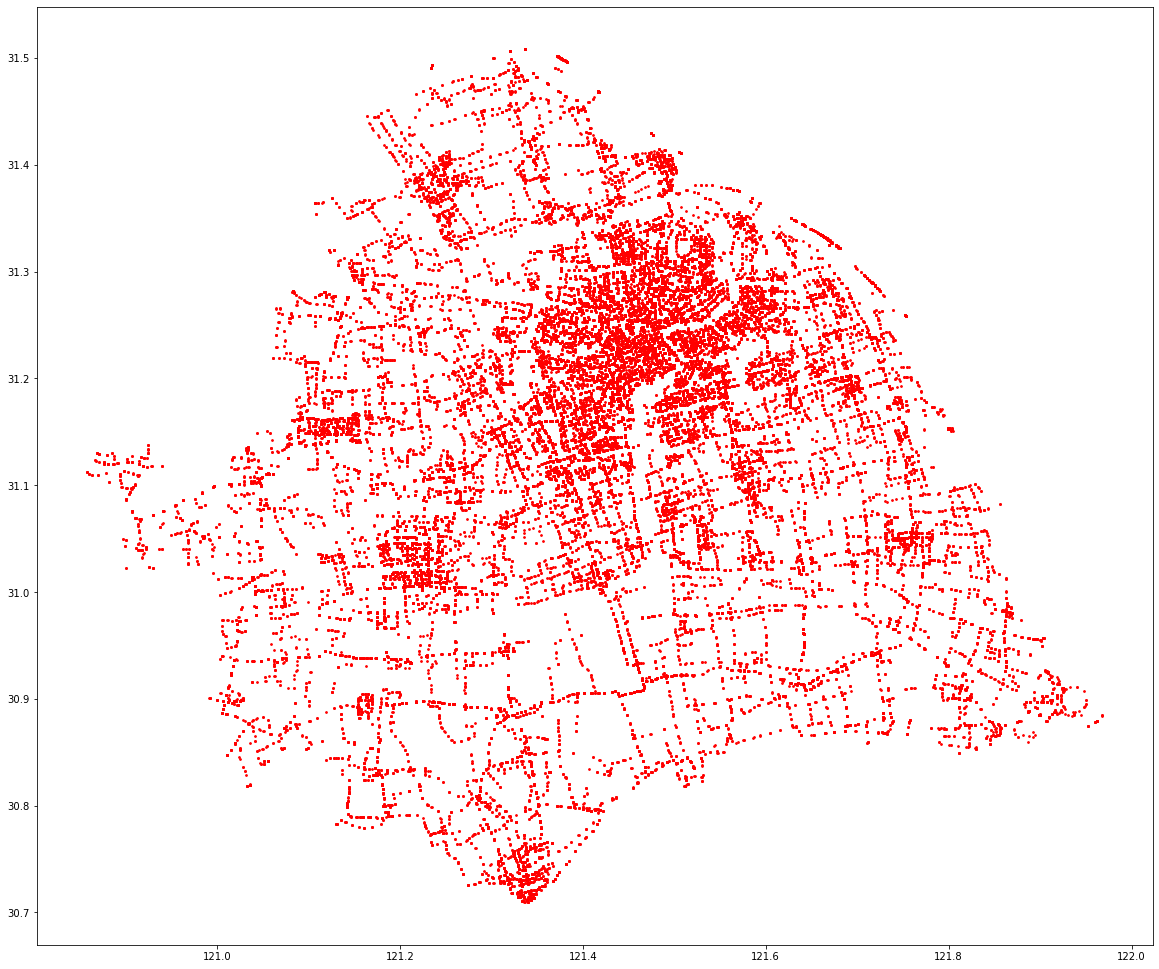

In [38]:
add_nodes.plot(figsize=(20,20),color='red',markersize=3)

In [39]:
add_nodes['x'] = add_nodes['geometry'].x
add_nodes['y'] = add_nodes['geometry'].y

In [40]:
add_nodes # 这个就是获得的离公交最近的walk线上的分割点，作为walk交叉口的补充

,geometry,osmid,x,y
0,POINT (121.39880 31.26374),100000,121.398801,31.263741
0,POINT (121.39880 31.26374),100001,121.398801,31.263741
1,POINT (121.39956 31.26240),100002,121.399562,31.262400
1,POINT (121.39956 31.26240),100003,121.399562,31.262400
2,POINT (121.40135 31.25666),100004,121.401345,31.256657
...,...,...,...,...
53095,POINT (121.52611 31.05016),176557,121.526114,31.050160
53095,POINT (121.52611 31.05016),176558,121.526114,31.050160
53096,POINT (121.52447 31.05865),176559,121.524468,31.058647
53096,POINT (121.52447 31.05865),176560,121.524468,31.058647


# 准备walk的分段数据（u，v）

In [41]:
res_copy = res.copy()

In [42]:
res_copy.head(1)   # 这里u,v是 walk上的

,osmid,station_names,label_left,line_name,x,y,geometry,index_right,u,v,key,length,label_right,wkt,out_dt
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387),67824,616810078,8955354756,1,164.218,walk_edge,"LINESTRING (121.3992316 31.2633834, 121.399253...","[[LINESTRING (121.3992316 31.2633834, 121.3992..."


In [43]:
res_copy.columns

Index(['osmid', 'station_names', 'label_left', 'line_name', 'x', 'y',
       'geometry', 'index_right', 'u', 'v', 'key', 'length', 'label_right',
       'wkt', 'out_dt'],
      dtype='object')

In [44]:
res_copy = res_copy[['u', 'v', 'key','out_dt']]

In [45]:
res_copy.head(1)

,u,v,key,out_dt
0,616810078,8955354756,1,"[[LINESTRING (121.3992316 31.2633834, 121.3992..."


In [46]:
res_copy['out_lines'] = res_copy['out_dt'].str.get(0)

In [47]:
res_copy

,u,v,key,out_dt,out_lines
0,616810078,8955354756,1,"[[LINESTRING (121.3992316 31.2633834, 121.3992...","[LINESTRING (121.3992316 31.2633834, 121.39925..."
0,8955354756,616810078,1,"[[LINESTRING (121.3978929 31.2636802, 121.3979...","[LINESTRING (121.3978929 31.2636802, 121.39792..."
1,9295036405,1448233118,0,"[[LINESTRING (121.3991475 31.2633169, 121.3992...","[LINESTRING (121.3991475 31.2633169, 121.39928..."
1,1448233118,9295036405,0,"[[LINESTRING (121.3996707 31.2620258, 121.3995...","[LINESTRING (121.3996707 31.2620258, 121.39956..."
2,3439590066,1255055270,0,"[[LINESTRING (121.4016528 31.2556249, 121.4013...","[LINESTRING (121.4016528 31.2556249, 121.40135..."
...,...,...,...,...,...
53095,1811961591,1811983811,0,"[[LINESTRING (121.5261039 31.0509556, 121.5261...","[LINESTRING (121.5261039 31.0509556, 121.52611..."
53095,1811983811,1811961591,0,"[[LINESTRING (121.5261345 31.0485429, 121.5261...","[LINESTRING (121.5261345 31.0485429, 121.52613..."
53096,1613391523,1690483655,0,"[[LINESTRING (121.5241739 31.0598278, 121.5244...","[LINESTRING (121.5241739 31.0598278, 121.52446..."
53096,1690483655,1613391523,0,"[[LINESTRING (121.5249593 31.0570115, 121.5249...","[LINESTRING (121.5249593 31.0570115, 121.52494..."


In [48]:
res_copy['osmid'] = add_nodes['osmid'] # 因为需要是一致的，所以直接赋osmid

In [49]:
res_copy

,u,v,key,out_dt,out_lines,osmid
0,616810078,8955354756,1,"[[LINESTRING (121.3992316 31.2633834, 121.3992...","[LINESTRING (121.3992316 31.2633834, 121.39925...",100000
0,8955354756,616810078,1,"[[LINESTRING (121.3978929 31.2636802, 121.3979...","[LINESTRING (121.3978929 31.2636802, 121.39792...",100001
1,9295036405,1448233118,0,"[[LINESTRING (121.3991475 31.2633169, 121.3992...","[LINESTRING (121.3991475 31.2633169, 121.39928...",100002
1,1448233118,9295036405,0,"[[LINESTRING (121.3996707 31.2620258, 121.3995...","[LINESTRING (121.3996707 31.2620258, 121.39956...",100003
2,3439590066,1255055270,0,"[[LINESTRING (121.4016528 31.2556249, 121.4013...","[LINESTRING (121.4016528 31.2556249, 121.40135...",100004
...,...,...,...,...,...,...
53095,1811961591,1811983811,0,"[[LINESTRING (121.5261039 31.0509556, 121.5261...","[LINESTRING (121.5261039 31.0509556, 121.52611...",176557
53095,1811983811,1811961591,0,"[[LINESTRING (121.5261345 31.0485429, 121.5261...","[LINESTRING (121.5261345 31.0485429, 121.52613...",176558
53096,1613391523,1690483655,0,"[[LINESTRING (121.5241739 31.0598278, 121.5244...","[LINESTRING (121.5241739 31.0598278, 121.52446...",176559
53096,1690483655,1613391523,0,"[[LINESTRING (121.5249593 31.0570115, 121.5249...","[LINESTRING (121.5249593 31.0570115, 121.52494...",176560


## 创建walk子段的uv

In [50]:
def get_u_vlst(x):
    if len(x['out_lines']) == 1:  # 有些点在起点或终点，则分割后只有一条记录，所以这里做判断，如果为1，则直接uv即可
        return [[x['u'],x['v']]]
    else:
        return [[x['u'],x['osmid']],[x['v'],x['osmid']]]

In [51]:
res_copy['u_v_list'] = res_copy.apply(get_u_vlst,axis=1)

In [52]:
# 如下分割点应该是起点或者终点

In [53]:
res_copy[res_copy['osmid'] == 102913]['out_lines']

2105    [LINESTRING (121.2122308 30.9336146, 121.21132...
Name: out_lines, dtype: object

In [54]:
res_copy[res_copy['osmid'] == 102913]['u_v_list']

2105    [[4166755760, 4192854798]]
Name: u_v_list, dtype: object

In [55]:
res_copy.head(1)

,u,v,key,out_dt,out_lines,osmid,u_v_list
0,616810078,8955354756,1,"[[LINESTRING (121.3992316 31.2633834, 121.3992...","[LINESTRING (121.3992316 31.2633834, 121.39925...",100000,"[[616810078, 100000], [8955354756, 100000]]"


In [56]:
res_copy['out_lines'].explode().reset_index()

,index,out_lines
0,0,"LINESTRING (121.3992316 31.2633834, 121.399253..."
1,0,LINESTRING (121.39880109638908 31.263741262735...
2,0,"LINESTRING (121.3978929 31.2636802, 121.397925..."
3,0,LINESTRING (121.39880109638908 31.263741262735...
4,1,"LINESTRING (121.3991475 31.2633169, 121.399285..."
...,...,...
148189,53096,LINESTRING (121.52446814270778 31.058646986579...
148190,53096,"LINESTRING (121.5249593 31.0570115, 121.524941..."
148191,53096,LINESTRING (121.52446814270778 31.058646986579...
148192,53097,"LINESTRING (121.5075914 31.0629558, 121.508050..."


In [57]:
res_copy['u_v_list'].explode().reset_index()

,index,u_v_list
0,0,"[616810078, 100000]"
1,0,"[8955354756, 100000]"
2,0,"[8955354756, 100001]"
3,0,"[616810078, 100001]"
4,1,"[9295036405, 100002]"
...,...,...
148189,53096,"[1690483655, 176559]"
148190,53096,"[1690483655, 176560]"
148191,53096,"[1613391523, 176560]"
148192,53097,"[1810740542, 176561]"


In [58]:
res_copy_x2 = pd.concat([
    res_copy['out_lines'].explode().reset_index(),
    res_copy['u_v_list'].explode().reset_index(),
    res_copy['key'].repeat([len(i) for i in res_copy['out_lines']]).reset_index(),
],axis=1)

In [59]:
res_copy_x2

,index,out_lines,index,u_v_list,index,key
0,0,"LINESTRING (121.3992316 31.2633834, 121.399253...",0,"[616810078, 100000]",0,1
1,0,LINESTRING (121.39880109638908 31.263741262735...,0,"[8955354756, 100000]",0,1
2,0,"LINESTRING (121.3978929 31.2636802, 121.397925...",0,"[8955354756, 100001]",0,1
3,0,LINESTRING (121.39880109638908 31.263741262735...,0,"[616810078, 100001]",0,1
4,1,"LINESTRING (121.3991475 31.2633169, 121.399285...",1,"[9295036405, 100002]",1,0
...,...,...,...,...,...,...
148189,53096,LINESTRING (121.52446814270778 31.058646986579...,53096,"[1690483655, 176559]",53096,0
148190,53096,"LINESTRING (121.5249593 31.0570115, 121.524941...",53096,"[1690483655, 176560]",53096,0
148191,53096,LINESTRING (121.52446814270778 31.058646986579...,53096,"[1613391523, 176560]",53096,0
148192,53097,"LINESTRING (121.5075914 31.0629558, 121.508050...",53097,"[1810740542, 176561]",53097,1


In [60]:
res_copy_x2['u'] = res_copy_x2['u_v_list'].str.get(0)
res_copy_x2['v'] = res_copy_x2['u_v_list'].str.get(1)

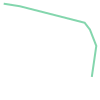

In [61]:
res_copy_x2['out_lines'][0]

In [62]:
res_copy_x2.head(1)

,index,out_lines,index,u_v_list,index,key,u,v
0,0,"LINESTRING (121.3992316 31.2633834, 121.399253...",0,"[616810078, 100000]",0,1,616810078,100000


In [63]:
add_edges = gpd.GeoDataFrame({
    'geometry':res_copy_x2['out_lines'],
    'key':res_copy_x2['key'],
    'u':res_copy_x2['u'],
    'v':res_copy_x2['v'],
},crs='epsg:4326')

In [64]:
add_edges

,geometry,key,u,v
0,"LINESTRING (121.39923 31.26338, 121.39925 31.2...",1,616810078,100000
1,"LINESTRING (121.39880 31.26374, 121.39856 31.2...",1,8955354756,100000
2,"LINESTRING (121.39789 31.26368, 121.39793 31.2...",1,8955354756,100001
3,"LINESTRING (121.39880 31.26374, 121.39888 31.2...",1,616810078,100001
4,"LINESTRING (121.39915 31.26332, 121.39929 31.2...",0,9295036405,100002
...,...,...,...,...
148189,"LINESTRING (121.52447 31.05865, 121.52459 31.0...",0,1690483655,176559
148190,"LINESTRING (121.52496 31.05701, 121.52494 31.0...",0,1690483655,176560
148191,"LINESTRING (121.52447 31.05865, 121.52417 31.0...",0,1613391523,176560
148192,"LINESTRING (121.50759 31.06296, 121.50805 31.0...",1,1810740542,176561


## 添加length，方便后面计算

In [65]:
add_edges = add_edges.to_crs(epsg=3857)

In [66]:
add_edges['length'] = add_edges.length

In [67]:
add_edges

,geometry,key,u,v,length
0,"LINESTRING (13514100.644 3667001.939, 13514103...",1,616810078,100000,81.774217
1,"LINESTRING (13514052.721 3667048.544, 13514026...",1,8955354756,100000,110.556961
2,"LINESTRING (13513951.621 3667040.591, 13513955...",1,8955354756,100001,110.556961
3,"LINESTRING (13514052.721 3667048.544, 13514061...",1,616810078,100001,81.774217
4,"LINESTRING (13514091.282 3666993.279, 13514106...",0,9295036405,100002,129.738020
...,...,...,...,...,...
148189,"LINESTRING (13528041.913 3640367.915, 13528055...",0,1690483655,176559,219.526073
148190,"LINESTRING (13528096.588 3640155.387, 13528094...",0,1690483655,176560,219.526073
148191,"LINESTRING (13528041.913 3640367.915, 13528009...",0,1613391523,176560,156.903528
148192,"LINESTRING (13526163.202 3640927.854, 13526214...",1,1810740542,176561,77.325973


In [68]:
add_edges = add_edges.to_crs(epsg=4326)

In [69]:
add_edges['label'] = 'walk_edge'

In [70]:
add_edges.head(1)

,geometry,key,u,v,length,label
0,"LINESTRING (121.39923 31.26338, 121.39925 31.2...",1,616810078,100000,81.774217,walk_edge


<AxesSubplot:>

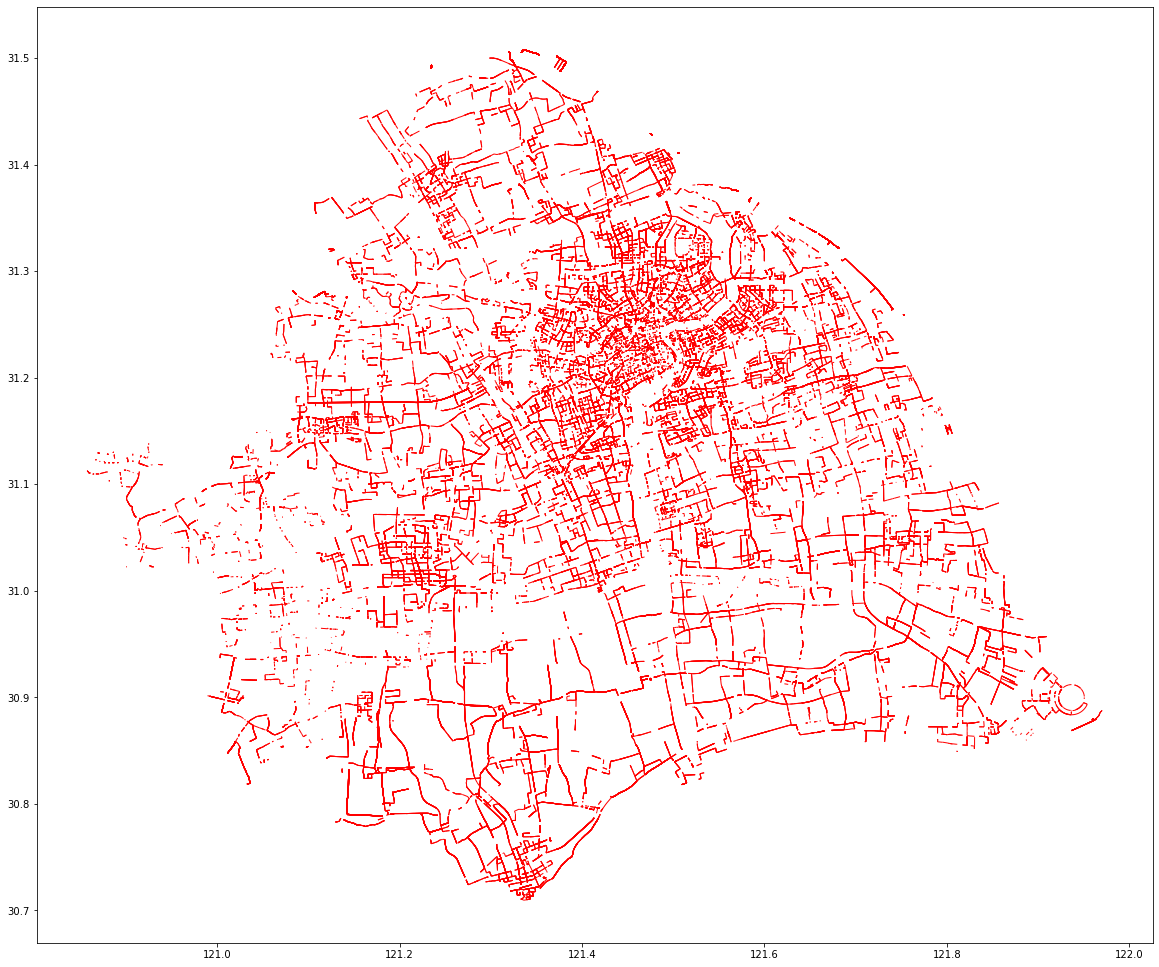

In [71]:
add_edges.plot(figsize=(20,20),color='red',lw=1)

# 创建公交站至add_nodes的uv

In [72]:
add_nodes = add_nodes.reset_index()
res = res.reset_index()

In [73]:
add_nodes.head(1)

,index,geometry,osmid,x,y
0,0,POINT (121.39880 31.26374),100000,121.398801,31.263741


In [74]:
res.head(1)

,index,osmid,station_names,label_left,line_name,x,y,geometry,index_right,u,v,key,length,label_right,wkt,out_dt
0,0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387),67824,616810078,8955354756,1,164.218,walk_edge,"LINESTRING (121.3992316 31.2633834, 121.399253...","[[LINESTRING (121.3992316 31.2633834, 121.3992..."


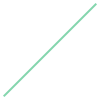

In [75]:
LineString([(1,2),(4,5)])

In [76]:
([(add_nodes['x'][0],add_nodes['y'][0]),(add_nodes['x'][1],add_nodes['y'][1])])

[(121.39880109638908, 31.263741262735344),
 (121.39880109638908, 31.263741262735344)]

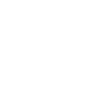

In [77]:
LineString([(121.39880109638908, 31.263741262735344), (121.39880109638908, 31.263741262735344)])

In [ ]:
# 这里要注意，是双向的。

In [78]:
edges1 = gpd.GeoDataFrame({'u':add_nodes['osmid'],
                  'v':res['osmid'],
                  'geometry':[LineString([(add_nodes['x'][i],add_nodes['y'][i]),
                                         (res['x'][i],res['y'][i])])\
                              for i in range(len(res))],
                 'key': [0 for i in range(len(res))]},
                 
                 crs='epsg:4326'
                )

In [79]:
edges1

,u,v,geometry,key
0,100000,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
1,100001,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
2,100002,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
3,100003,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
4,100004,2,"LINESTRING (121.40135 31.25666, 121.40135 31.2...",0
...,...,...,...,...
76557,176557,53095,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
76558,176558,53095,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
76559,176559,53096,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0
76560,176560,53096,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0


In [80]:
edges2 = gpd.GeoDataFrame({'v':add_nodes['osmid'],
                  'u':res['osmid'],
                  'geometry':[LineString([(add_nodes['x'][i],add_nodes['y'][i]),
                                         (res['x'][i],res['y'][i])])\
                              for i in range(len(res))],
                 'key': [0 for i in range(len(res))]},
                 
                 crs='epsg:4326'
                )

In [81]:
edges2

,v,u,geometry,key
0,100000,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
1,100001,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
2,100002,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
3,100003,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
4,100004,2,"LINESTRING (121.40135 31.25666, 121.40135 31.2...",0
...,...,...,...,...
76557,176557,53095,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
76558,176558,53095,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
76559,176559,53096,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0
76560,176560,53096,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0


In [82]:
edgesx = pd.concat([edges1,edges2],ignore_index=True)

In [83]:
edgesx

,u,v,geometry,key
0,100000,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
1,100001,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
2,100002,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
3,100003,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
4,100004,2,"LINESTRING (121.40135 31.25666, 121.40135 31.2...",0
...,...,...,...,...
153119,53095,176557,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
153120,53095,176558,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
153121,53096,176559,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0
153122,53096,176560,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0


In [84]:
edgesx['key'] = 0

In [85]:
edgesx

,u,v,geometry,key
0,100000,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
1,100001,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0
2,100002,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
3,100003,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0
4,100004,2,"LINESTRING (121.40135 31.25666, 121.40135 31.2...",0
...,...,...,...,...
153119,53095,176557,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
153120,53095,176558,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0
153121,53096,176559,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0
153122,53096,176560,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0


In [86]:
edgesx = edgesx.to_crs(epsg=3857)

In [87]:
edgesx['length'] = edgesx['geometry'].length

In [88]:
edgesx = edgesx.to_crs(epsg=4326)

In [89]:
edgesx

,u,v,geometry,key,length
0,100000,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0,16.526820
1,100001,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0,16.526820
2,100002,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0,7.243833
3,100003,1,"LINESTRING (121.39956 31.26240, 121.39950 31.2...",0,7.243833
4,100004,2,"LINESTRING (121.40135 31.25666, 121.40135 31.2...",0,0.995866
...,...,...,...,...,...
153119,53095,176557,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0,11.307657
153120,53095,176558,"LINESTRING (121.52611 31.05016, 121.52601 31.0...",0,11.307657
153121,53096,176559,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0,162.268507
153122,53096,176560,"LINESTRING (121.52447 31.05865, 121.52307 31.0...",0,162.268507


<AxesSubplot:>

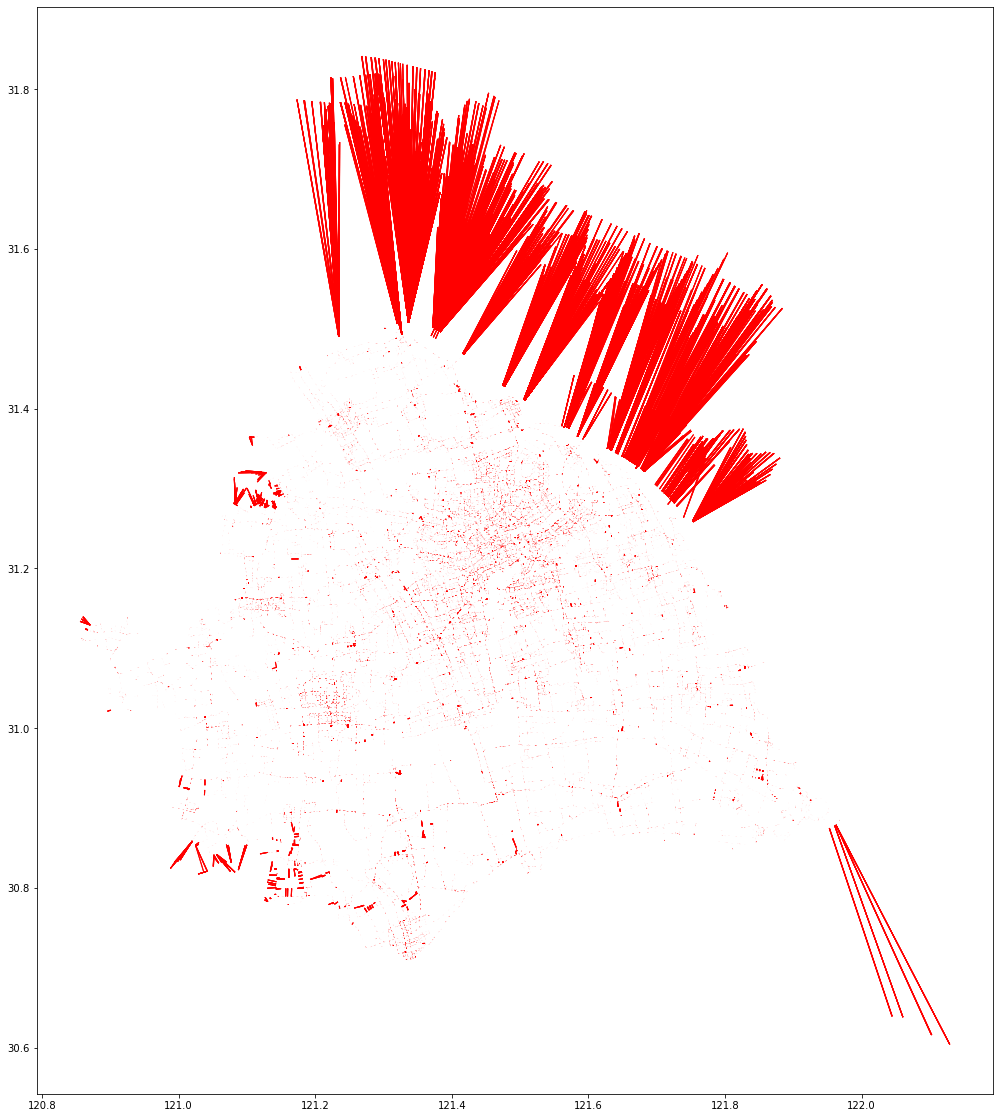

In [90]:
edgesx.plot(figsize=(20,20),color='red',lw=1)

# 最终gdf数据准备数据

## 点数据

In [91]:
add_nodes.head(1) # 这是增加的点（在步行道路上）

,index,geometry,osmid,x,y
0,0,POINT (121.39880 31.26374),100000,121.398801,31.263741


In [92]:
pt_nodes.head(1) # 这是公交站点

,osmid,station_names,label,line_name,x,y,geometry
0,0,上海西站,地面公交,01路(上海西站--蓝村路南泉路),121.398821,31.263867,POINT (121.39882 31.26387)


In [93]:
wk_nodes.head(1) # 这是道路交叉口

,osmid,y,x,label,geometry
0,91408837,30.919677,121.696103,walk_node,POINT (121.69610 30.91968)


In [94]:
add_nodes['label'] = 'walk_node_add'

In [95]:
add_nodes.columns

Index(['index', 'geometry', 'osmid', 'x', 'y', 'label'], dtype='object')

In [96]:
nodes_all = pd.concat([
    add_nodes[['geometry', 'osmid', 'x', 'y', 'label']],
    wk_nodes[['geometry', 'osmid', 'x', 'y', 'label']],
    pt_nodes[['geometry', 'osmid', 'x', 'y', 'label']]
],ignore_index=True).set_index('osmid')

In [97]:
nodes_all

,geometry,x,y,label
osmid,,,,
100000,POINT (121.39880 31.26374),121.398801,31.263741,walk_node_add
100001,POINT (121.39880 31.26374),121.398801,31.263741,walk_node_add
100002,POINT (121.39956 31.26240),121.399562,31.262400,walk_node_add
100003,POINT (121.39956 31.26240),121.399562,31.262400,walk_node_add
100004,POINT (121.40135 31.25666),121.401345,31.256657,walk_node_add
...,...,...,...,...
53093,POINT (121.52779 31.03261),121.527790,31.032608,轨道交通
53094,POINT (121.52628 31.04320),121.526282,31.043200,轨道交通
53095,POINT (121.52601 31.05016),121.526013,31.050159,轨道交通


## 边数据

In [98]:
pt_edges.head(1)

,u,v,key,label,length,wkt,geometry
0,37827,37828,0,地面公交,355.240859,LINESTRING (121.3988208531572 31.2638670382169...,"LINESTRING (121.39882 31.26387, 121.39873 31.2..."


In [99]:
wk_edges.head(1)

,u,v,key,length,label,wkt,geometry
0,91408837,9443491114,0,229.223,walk_edge,"LINESTRING (121.6961033 30.9196765, 121.695975...","LINESTRING (121.69610 30.91968, 121.69598 30.9..."


In [100]:
edgesx.head(1)

,u,v,geometry,key,length
0,100000,0,"LINESTRING (121.39880 31.26374, 121.39882 31.2...",0,16.52682


In [101]:
edgesx['label'] = 'walk_edge_add'

In [102]:
edges_all = pd.concat([
    pt_edges[['geometry', 'label', 'u', 'v', 'key']],
    wk_edges[['geometry', 'label', 'u', 'v', 'key']],
    edgesx[['geometry', 'label', 'u', 'v', 'key']]
],ignore_index=True).set_index(['u','v','key'])

In [103]:
edges_all.head(1)

,,,geometry,label
u,v,key,,
37827,37828,0,"LINESTRING (121.39882 31.26387, 121.39873 31.2...",地面公交


# 创建网络

In [104]:
G = ox.graph_from_gdfs(nodes_all, edges_all)

C:\Users\think\anaconda3\envs\ox\lib\site-packages\osmnx\utils_graph.py:155: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  warnings.warn(


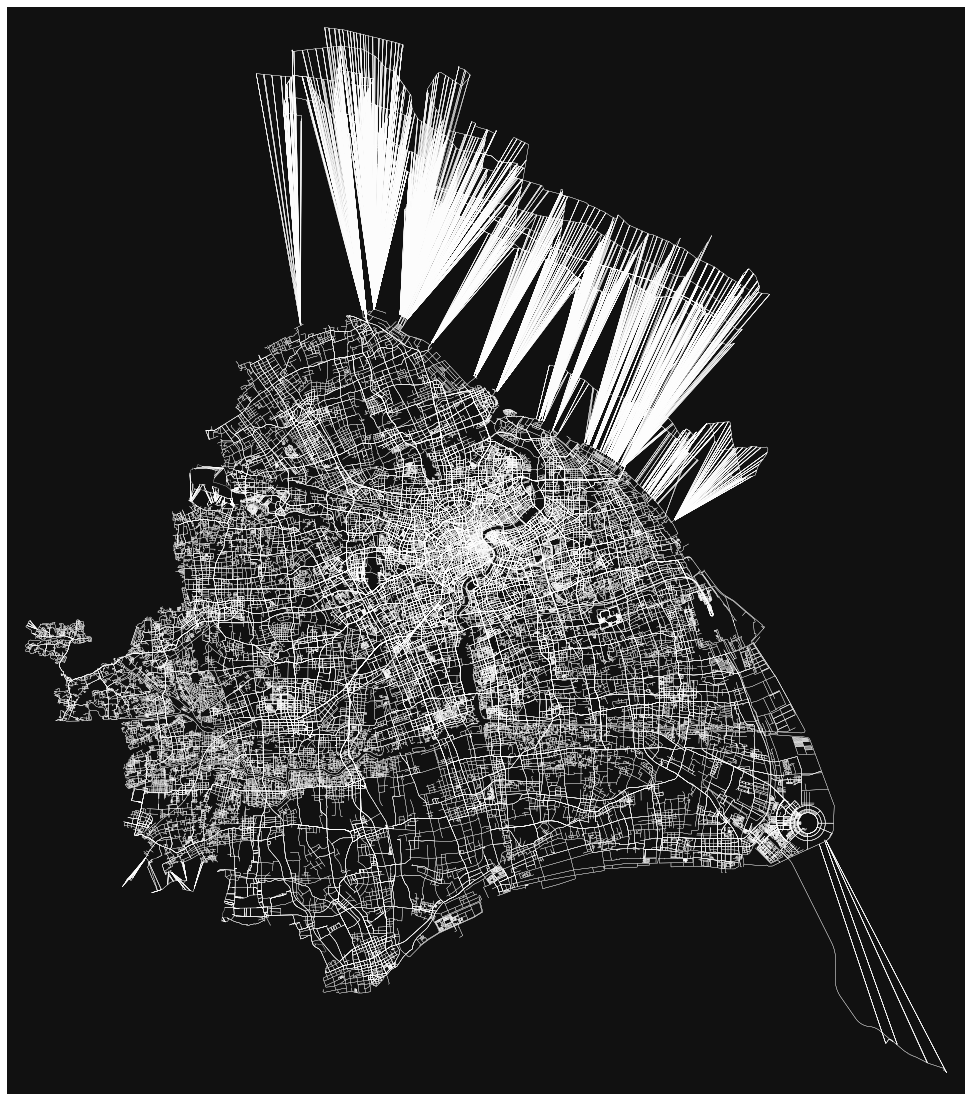

In [105]:
fig, ax = ox.plot_graph(G,figsize=(20,20),
                        node_color="red",
                        node_size=0,
                        edge_linewidth=0.3,
                        edge_color="w",
             )

In [ ]:
ox.save_graphml(G, filepath="./SHANGHAI/shanghai.graphml")

In [ ]:
nodes_all.index

In [ ]:
routes = ox.shortest_path(G, 10000, 10000, weight="length")
routes

In [ ]:
routes